# Step 1:  Implement the Histogram of Curvature Scale

Write a function called HoCS that returns a histogram of curvature scale feature vector for a given region.  The inputs to your function should be:

- `B`: a binary that contains exactly one foreground connected component.
- `min_scale`: The samllest scale (circle radius) at which to calcluate curvature
- `max_scale`: The largest scale (circle radius) at which to calculate curvature
- `increment`: The increment at which intermediate curvatures should be calculated (must be a positive integer)
- `num_bins`: The number of bins in the histogram of curvature for a single scale (must be a positive integer)

Your function should compute a histogram of curvature for each scale, starting at `min_scale` ending at (at most) `max_scale`, and for intermediate scales at increments of `increment`.  For example, if `min_scale`=4 and `max_scale`=20, and `increment`=3, then the function should compute a histogram of curvature for scales 4, 7, 10, 13, 16, and 19.  Each histogram at each scale should have `num_bins` bins.  Curvature must be computed using the normalized area integral invariant method described on Slide 39 of the Topic 9 lecture notes.  

Normalize each histogram at each scale.

To keep things straightforward, your functions hould only consider the outer perimeter of the input region; ignore the boundaries of holes in the region.

After computing the histogram of curvature at each of the specified scales, all of the histograms should be concatenated into a single one-dimensional array (feature vector) and then returned.

_Implementation hint:  You can calculate the normalized area integral invariant of each pixel efficiently using linear filtering.  You will find the function `skimage.morphology.disk()` function useful for designing the appropriate filter masks._

_Implementation hint:  Most of the heavy lifting here can be done with module functions from `skimage`, `numpy`, and `scipy`.  Many of the functions mentioned in class and in the notes will be useful.  One that we might not have covered, but will be very handy is `numpy.histogram()`.  When use use it, makes sure you specify both the `bins` and `range` optional arguments.  Also note that `numpy.histogram()` returns TWO things.  You only need the first one, so make sure you write your function call like this:_

`the_histogram, stuff_you_dont_need = np.histogram(...)`



In [1]:
import scipy.ndimage as nd
import skimage.segmentation as seg
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology as morph
import skimage.util as util
import skimage.transform as trans

%matplotlib inline

def HoCS(B, min_scale, max_scale, increment, num_bins):
    '''
    Computes a histogram of curvature scale for the shape in the binary image B.  
    Boundary fragments due to holes are ignored.
    :param B: A binary image consisting of a single foreground connected component.
    :param min_scale: smallest scale to consider (minimum 1)
    :param max_scale: largest scale to consider (max_scale > min_scale)
    :param increment:  increment on which to compute scales between min_scale and max_scale
    :param num_bins: number of bins for the histogram at each scale
    :return: 1D array of histograms concatenated together in order of increasing scale.
    
    Note: a curvature values are between 0.0 and 1.0 are interpreted thusly:
       0.0 - values close to 0 arise from highly convex points.
       0.5 - no curvature
       1.0 - values close to 1 arise from highly concave points.

    This solution uses the Area Integeral Invariant from:

    Siddharth Manay, Daniel Cremers, Byung-Woo Hong, Anthony J. Yezzi and Stefano
    Soatto.  Integral Invariants for Shape Matching, IEEE Transactions on Pattern
    Analysis and Machine Intelligence, Vol 28, No. 10, pp. 1602-1618, 2006.
 
    And combines it with the curvature scale histogramming technique used in:

    Neeraj Kumar, Peter N. Belhumeur, Arijit Biswas, David W. Jacobs, W. John Kress,
    Ida Lopez, João V. B. Soares.  Leafsnap: A Computer Vision System for Automatic
    Plant Species Identification, Proceedings of the 12th European Conference on
    Computer Vision (ECCV), 2012.
    '''
    
    # Check input validity
    if max_scale < min_scale:
        raise ValueError('max_scale must be larger than min_scale')
    
    if num_bins < 1:
        raise ValueError('num_bins must be >= 1')
    
    # Assume B has only one connected component
    b_holes_filled = nd.binary_fill_holes(B)
    
    # Get the locations boundary points using the method on slide 71 of Topic 06.
    bp = np.where(seg.find_boundaries(b_holes_filled, connectivity=1, mode='inner') > 0)
    bp = np.transpose(np.vstack(bp))
    
    # iterate over scales
    histograms = []
    for radius in np.arange(min_scale, max_scale+1, increment):

        # Construct linear filter for calculating area integral invariant.
        # divide disk mask by number of 1-entries, this will respond as the 
        # percentage of 1-entries that are covering the foreground region 
        # at each pixel.
        disk = morph.disk(radius) 
        disk = disk / np.sum(disk)
        
        # Filter the input image -- gotta convert it to float first or the output will be boolean
        # (which is bad because all our filter responses would get rounded to zero).
        c = nd.filters.convolve(util.img_as_float(b_holes_filled), disk)
            
        # extract the filter response for boundary pixels only.
        curvatures= c[bp[:,0], bp[:,1]]
        
        # Get the histogram of the curvatures extracted and append to the list of histograms for each scale.
        h, bin_edges = np.histogram(curvatures, bins=num_bins, range=(0.0,1.0))
        histograms.append(h / len(curvatures))
        
    # Horizontally concatenate all the histograms and return the resulting array.
    return np.hstack(histograms)

        

        
    

# Step 2: Test your HoCS function.

Run HoCS on `threshimage_0001.png` from the ground truth for assignment 3.  Use `min_scale=5`, `max_scale=25`, `increment=10`, `num_bins=10`.  Plot the resulting feature vector as a bar graph.  Set the y-axis limits to be between 0.0 and 1.0.  You should get a result that matches the sample output in the assignment description.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from uint8 to bool
  .format(dtypeobj_in, dtypeobj_out))


(0, 1)

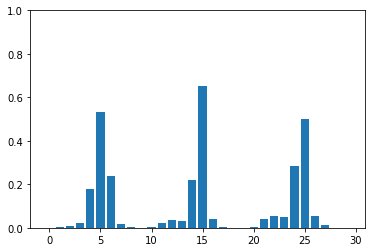

In [7]:
import skimage.io as io

min_scale=5
max_scale=25
increment=10
num_bins=10

B = util.img_as_bool(io.imread('leaftraining/threshimage_0001.png'))

feature = HoCS(B, min_scale, max_scale, increment, num_bins)

plt.bar(range(len(feature)), feature)
plt.ylim((0,1))


# Step 3: Calculate training features.

Use your function from Step 1 to compute the HoCS feature for each of the training images.  Use them to train a k-nearest neigbour classifier.  It is up to you to determine the parameters for the HoCS feature such as `min_scale`, `max_scale`, etc. to maximize the classification rate.  This will require some experimentation.  Slides 19-12 of Topic 12 lecture notes will be helpful here.

In [8]:
import os as os

# Create a class label vector for the training images.
labels = np.ones(10, dtype='int')
training_labels = np.hstack( (labels, labels*2, labels *3) )

min_scale=5
max_scale=30
increment=5
num_bins=15

# Calculate the feature vectors for the training images
training = []
for root, dirs, files in os.walk('./leaftraining'):
    for f in files:
        if f[-4:] == '.png':
            print('Calculating features for', f)
            B = io.imread(os.path.join(root, f))
            features = HoCS(B, min_scale, max_scale, increment, num_bins)
            training.append(features)
            
training = np.vstack(training)







            


Calculating features for threshimage_0160.png
Calculating features for threshimage_0174.png
Calculating features for threshimage_0175.png
Calculating features for threshimage_0161.png
Calculating features for threshimage_0001.png
Calculating features for threshimage_0015.png
Calculating features for threshimage_0163.png
Calculating features for threshimage_0162.png
Calculating features for threshimage_0002.png
Calculating features for threshimage_0166.png
Calculating features for threshimage_0007.png
Calculating features for threshimage_0011.png
Calculating features for threshimage_0005.png
Calculating features for threshimage_0165.png
Calculating features for threshimage_0171.png
Calculating features for threshimage_0010.png
Calculating features for threshimage_0089.png
Calculating features for threshimage_0100.png
Calculating features for threshimage_0105.png
Calculating features for threshimage_0104.png
Calculating features for threshimage_0110.png
Calculating features for threshima

# Step 4: Train the KNN classifier using the feature vectors from the training images.

You have another opportunity here to optimize parameters.  You can experiment with the options for the KNN classifier (in partiuclar n_neighbors) to try to obtain better classification rates.  But you won't really be able to do this until after step 6, so just use default parameters to start with. 

Hint: The steps in this notebook are broken up the way they are so that you can adjust the parameters of training tye classifier and then go and perform the classfication without having to re-run the calculation of the features in steps 3 and 5.  You can adjust the parameters here in step 4, and then go and re-run the test set in Step 6 without running step 5 over again -- which is good because step 5 will take a while to run.  Of course you will have to recalculate the features each time you restart PyCharm or the Jupyter Notebook server.

In [12]:
# Train the KNN classifier
import sklearn.neighbors as neigh

KNN = neigh.KNeighborsClassifier(n_neighbors=1)
KNN.fit(training, training_labels)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

# Step 5: Calculate the testing features.

Compute the HoCS features for all of the testing images.  Use the same HoCS parameters you did in Step 3.

In [ ]:
# Create a class label vector for the testing images.
labels1 = np.ones(50, dtype='int')
labels2 = np.ones(27, dtype='int')
labels3 = np.ones(52, dtype='int')

testing_labels = np.hstack( (labels1, labels2*2, labels3*3) )

# Calculate the feature vectors for the testing images
testing = []
for root, dirs, files in os.walk('./leaftesting'):
    for f in files:
        if f[-4:] == '.png':
            print('Calculating features for', f)
            B = io.imread(os.path.join(root, f))
            features = HoCS(B, min_scale, max_scale, increment, num_bins)
            testing.append(features)
            
testing = np.vstack(testing)

Calculating features for image_0185.png
Calculating features for image_0152.png
Calculating features for image_0146.png
Calculating features for image_0026.png
Calculating features for image_0033.png
Calculating features for image_0027.png
Calculating features for image_0147.png
Calculating features for image_0153.png
Calculating features for image_0184.png
Calculating features for image_0186.png
Calculating features for image_0179.png
Calculating features for image_0145.png
Calculating features for image_0151.png
Calculating features for image_0031.png
Calculating features for image_0025.png
Calculating features for image_0024.png
Calculating features for image_0030.png
Calculating features for image_0150.png
Calculating features for image_0144.png
Calculating features for image_0178.png
Calculating features for image_0140.png
Calculating features for image_0154.png
Calculating features for image_0168.png
Calculating features for image_0034.png
Calculating features for image_0020.png


# Step 6: Classfiy the testing features.

Classify the training features.

Determine the classification rate and the confusion matrix by comparing the results of the classifier to the true class labels for each image.  

Print out the filenames of incorrectly classified images.

Print the confusion matrix (you don't have to print the row/column indicies as in the example in the assignment description), just the rows and columns of the matrix itself.   Confusion matrix is explained in the background section of the assignment description document.

Print the correct classification rate.  Classification rate is explained in the Topic 12 notes and in the background section of the assignment description document.

It should be very easy to get a classficiation rate more than 90%; with well-chosen parameters for your HoCS features and the KNN classifier you should be able to get as much as 95%.

In [9]:
predictions = KNN.predict(testing)

# Construct a boolean array that denotes which images were correctly classified.
correct_labels = predictions==testing_labels

# obtain the filenames of images that were incorrectly classified.
incorrectly_classified = [ files[i] for i in range(len(files)) if not correct_labels[i] ]

# Print out the names of incorrectly classified images.
for f in incorrectly_classified:
    print(f, 'was incorrectly classified.')
print()  
    
# Compute and print out the confusion matrix.
confusion = np.zeros((3, 3), dtype='int')

for i in range(len(predictions)):
    confusion[testing_labels[i]-1, predictions[i]-1] += 1
    
print('The confusion matrix is:')
for x in confusion:
    print('{:5}, {:5}, {:5}'.format(x[0], x[1], x[2]))
print()

# Compute and print out the classification rate.
correct_rate = np.sum(correct_labels) / len(predictions)
print('The classification rate was', correct_rate*100, 'percent.')




NameError: name 'KNN' is not defined

# Step 7: Reflections

Answer the following questions right here in this block:

- Discuss your HoCS parameters and how you arrived at them.  Why did you choose the scales and number of histogram bins that you did?  Are there other values that work just as well?   Likely you tested other HoCS parameters that resulted in worse performance before finding the ones that worked best -- what were some of them and why do you think the performance was worse?

	_Your answer:_

- Discuss your choice of KNN classifier parameters and how you arrived at them (think about the same types of questions as in the previous point).

	_Your answer:_

- Discuss the misclassified images.  Were there any classes that were particularly difficult to distinguish?  Is there anything unusual about any of the misclassified images that would cuase them to be misclassified?  If so, explain

	_Your answer:_
